In [2]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'german'
seed = 1
np.random.seed(seed)

In [3]:
def get_scaler(preprocessor):
    scaler = preprocessor.transformers_[0][1].named_steps['scaler']
    return scaler

In [4]:
credit = np.genfromtxt('data/german/german.data-numeric')
categorical_features=[]

In [5]:
X, y = credit[:,:-1], credit[:,-1:].squeeze()

In [6]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


Epoch 1, Loss G: 0.5930905389278085, loss_bb: 0.5930905389278085
Epoch 2, Loss G: 0.6219964144312717, loss_bb: 0.6219964144312717
Epoch 3, Loss G: 0.6038241054235786, loss_bb: 0.6038241054235786
Epoch 4, Loss G: 0.6108893301016224, loss_bb: 0.6108893301016224
Epoch 5, Loss G: 0.6446916876891358, loss_bb: 0.6446916876891358
Epoch 6, Loss G: 0.6158836441688524, loss_bb: 0.6158836441688524
Epoch 7, Loss G: 0.6340162570410218, loss_bb: 0.6340162570410218
Epoch 8, Loss G: 0.6516694979878505, loss_bb: 0.6516694979878505
Epoch 9, Loss G: 0.6177254737312637, loss_bb: 0.6177254737312637
Epoch 10, Loss G: 0.6278216277401676, loss_bb: 0.6278216277401676
Epoch 11, Loss G: 0.6363836677351286, loss_bb: 0.6363836677351286
Epoch 12, Loss G: 0.6300154556281331, loss_bb: 0.6300154556281331
Epoch 13, Loss G: 0.5982745695345484, loss_bb: 0.5982745695345484
Epoch 14, Loss G: 0.6047674253143165, loss_bb: 0.6047674253143165
Epoch 15, Loss G: 0.6294122567390644, loss_bb: 0.6294122567390644
Epoch 16, Loss G: 0

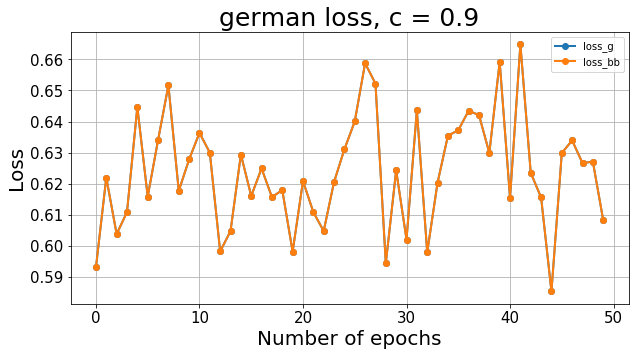

In [7]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))
batch_size = 50
epochs = 50
confidence_level = 0.9 
gen_lr = 2e-5
loss = 'log'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
                            blackbox_model=rf, 
                            preprocessing_pipeline=preprocessor, 
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z, 
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    )

rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

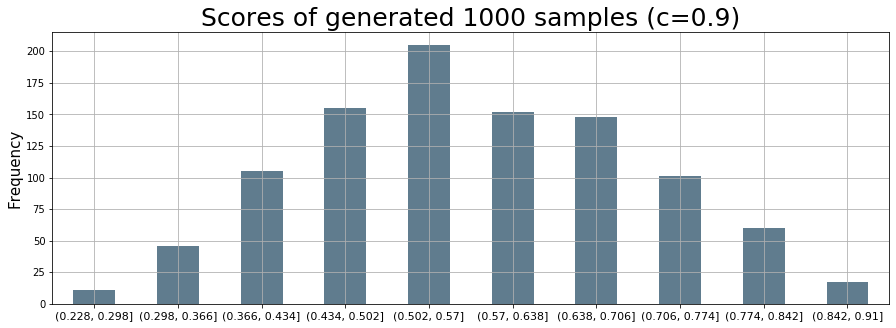

In [8]:
# check confidence for the generated samples
samples = 1000
confidence_levels = [confidence_level]

for c in confidence_levels:
#     rf_ctgan = CTGANSynthesizer.load(f"{MODELS_PATH}/ctgan_c_{c}.pkl") 
    test_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(test_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    counts = pd.value_counts(y_conf_gen, bins=10, sort=False)
    plt.figure()
    ax = counts.plot.bar(rot=0, grid=True, color='#607c8e', figsize=(15,5))
    ax.set_xticklabels([str(interval) for interval in counts.index], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=15)

    ax.set_title(f'Scores of generated {samples} samples (c={c})', fontsize=25)

In [10]:
scaler = get_scaler(preprocessor)

# find samples s such that s.confidence > c 
indecies = np.argwhere(y_conf_gen>confidence_level).squeeze()
print(y_conf_gen[indecies])

0.91
